# Tâche #1 : Classification d'incidents avec des modèles *Transformers*

On reprend, comme au premier travail, le thème de la classification de descriptions d’incidents. Cependant, la définition des classes est différente pour ce travail et de nouveaux jeux de données ont été produits. Le corpus de textes contient 3 partitions : 
-	Un fichier d’entraînement -  *data/incidents_train.json*
-	Un fichier de validation -  *data/incidents_dev.json*
-	Un fichier de test - *data/incidents_test.json*
 
Utilisez la librairie *HuggingFace* pour accomplir cette tâche. On vous demande plus spécifiquement d’utiliser 2 modèles: le modèle *bert-base-uncased* et un autre modèle de votre choix. 

Les consignes pour cette tâche sont: 
- Nom du notebook : *t1_classification.ipynb* (ce notebook)
- Tokenisation : Celle fournie par les tokeniseurs accompagnant les modèles transformers. 
- Plongements de mots : Ceux du modèle transformer. 
- Normalisation : Lettre en minuscule pour Bert (rien à faire, le tokenizer s’en occupe). Aucune contrainte pour le 2e modèle mais il est préférable de ne pas altérer le texte (sauf minuscule). 
- Choix du 2e transformer: Un modèle encodeur préentraîné pour l’anglais ou multilingue. Le modèle ne doit pas être une variante de Bert (p. ex. DistilBert). Me consulter en cas de doute.
- Entraînement : Un affinage (*fine-tuning*) du modèle, pas de préentraînement demandé (*no further pretraining*). 
- Analyse : Présentez clairement vos résultats et faites-en l’analyse. Comparez les résultats obtenus avec les 2 modèles.    

Vous pouvez ajouter au *notebook* toutes les cellules dont vous avez besoin pour votre code, vos explications ou la présentation de vos résultats. Vous pouvez également ajouter des sous-sections (par ex. des sous-sections 1.1, 1.2 etc.) si cela améliore la lisibilité.

Notes :
- Évitez les bouts de code trop longs ou trop complexes. Par exemple, il est difficile de comprendre 4-5 boucles ou conditions imbriquées. Si c'est le cas, définissez des sous-fonctions pour refactoriser et simplifier votre code. 
- Expliquez sommairement votre démarche.
- Expliquez les choix que vous faites au niveau de la programmation et des modèles (si non trivial).
- Analyser vos résultats. Indiquez ce que vous observez, si c'est bon ou non, si c'est surprenant, etc. 
- Une analyse quantitative et qualitative d'erreurs est intéressante et permet de mieux comprendre le comportement d'un modèle.

## 1. Création du jeu de données (*les 3 partitions du dataset*)

In [4]:
#Importation des libriaries nécessaires 
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, ElectraConfig, ElectraModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import torch

In [5]:
import json

def load_json_data(filename):
    with open(filename, 'r') as fp:
        data = json.load(fp)
    return data

In [6]:
#Lecture des fichiers de données
warnings.filterwarnings('ignore')
train_json_fn = "./data/incidents_train.json"
val_json_fn = "./data/incidents_dev.json"
test_json_fn = "./data/incidents_test.json"

#Création d'un dataset composé de 3 partitions : Train, Eval et test
one_dataset_files = {"train": train_json_fn, "eval": val_json_fn, "test" : test_json_fn}
one_dataset = load_dataset("json", data_files=one_dataset_files)

In [7]:
# Structure du dataset : 
one_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2475
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 531
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 531
    })
})

### 1.1 Préparation des données

Le but étant de prédire la classification d'un texte, la premiére étape est de faire une inspection de la structure du jeu de données fourni.
La structure obtenue du Dataset est composée de 3 partitions. Nous avons un échantillon de 2475 textes pour l'entrainement, de 531 textes pour l'évaluation et de 531 textes pour les tests. Dans ce cas, nous avons 9 classes distinctes à prédire.
La dimension "label" est de type ***objet*** et sera donc converti en format ***int*** pour pouvoir être utilisé par les algorithmes d'apprentissage.


In [10]:
# On tranforme les données en un dataframe de type Pandas pour la facilité de manipulation et d'inspection des données.
my_df_train = pd.DataFrame(one_dataset["train"])
my_df_eval = pd.DataFrame(one_dataset["eval"])
my_df_test = pd.DataFrame(one_dataset["test"])

In [11]:
#Composition du Dataframe
print(my_df_train.describe())
print(my_df_eval.describe())
print(my_df_test.describe())

                                                     text label
count                                                2475  2475
unique                                               2475     9
top      At approximately 8:50 a.m. on October 29  199...     5
freq                                                    1   958
                                                     text label
count                                                 531   531
unique                                                531     9
top      At approximately 11:30 a.m. on December 8  20...     5
freq                                                    1   210
                                                     text label
count                                                 531   531
unique                                                531     9
top      An employee of a contractor was using a front...     5
freq                                                    1   191


In [12]:
my_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2475 non-null   object
 1   label   2475 non-null   object
dtypes: object(2)
memory usage: 38.8+ KB


In [13]:
# NB de classes à prédire:
nb_labels = len(pd.unique(my_df_train["label"]))


In [14]:
my_df_train.dtypes

text     object
label    object
dtype: object

In [15]:
#Transformer le "label" en format numérique entier
my_df_train['label'] = my_df_train['label'].astype(int)
my_df_eval['label'] = my_df_eval['label'].astype(int)
my_df_test['label'] = my_df_test['label'].astype(int)

In [16]:
print(my_df_train.dtypes, my_df_eval.dtypes,my_df_test.dtypes)

text     object
label     int32
dtype: object text     object
label     int32
dtype: object text     object
label     int32
dtype: object


In [17]:
#Reconvertion en Dataset
my_dataset_dict = {'train' : Dataset.from_pandas(my_df_train),
                   'eval' : Dataset.from_pandas(my_df_eval),
                   'test' : Dataset.from_pandas(my_df_test)
                  }
my_dataset = DatasetDict(my_dataset_dict)

In [18]:
my_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2475
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 531
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 531
    })
})

In [19]:
my_dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int32', id=None)}

In [20]:
my_dataset['eval'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int32', id=None)}

In [21]:
my_dataset['test'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int32', id=None)}

### 1.2 Analyse des données

La fréquence des différentes étiquettes montre un certain déséquilibre dans le jeu de données de départ. La classe à prédire numéro 5 est surreprésentée par rapport aux autres classes dans le jeu d'entrainement, d'évaluation et de test. Également, nous avons très peu d'échantillons de la classe 1, 3, 4 et 6. Ceci pourrait restreinte la capacité de nos futurs modèles à bien prédire ces classes.


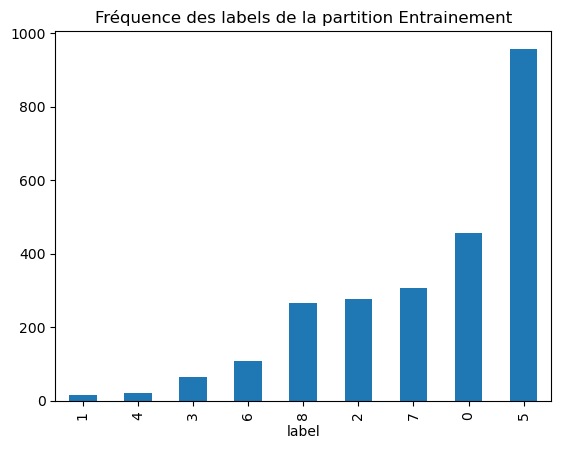

In [24]:
my_df_train['label'].value_counts(ascending=True).plot.bar()
plt.title("Fréquence des labels de la partition Entrainement")
plt.show()

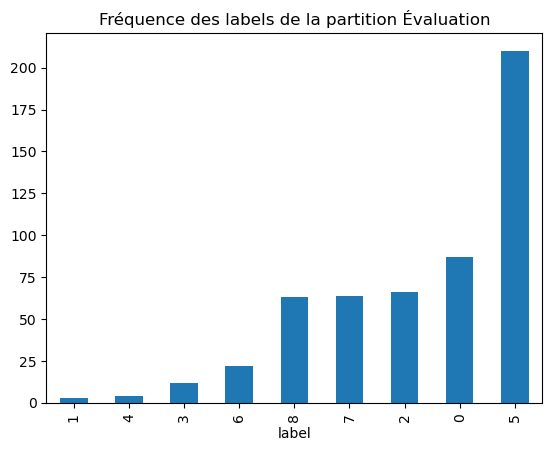

In [25]:
my_df_eval['label'].value_counts(ascending=True).plot.bar()
plt.title("Fréquence des labels de la partition Évaluation")
plt.show()

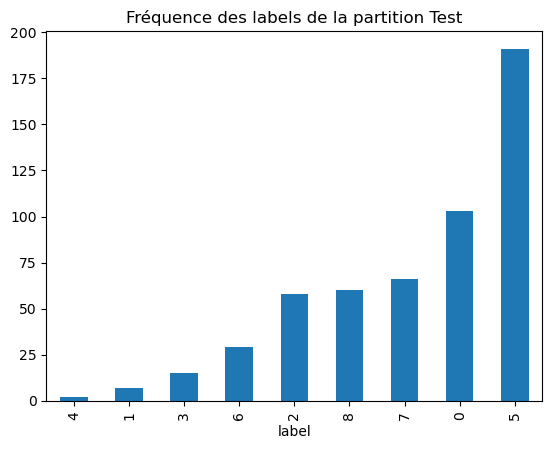

In [26]:
my_df_test['label'].value_counts(ascending=True).plot.bar()
plt.title("Fréquence des labels de la partition Test")
plt.show()

In [27]:
#affichage de quelques entrés du jeu de données d'entrainement 
my_df_train.head()

,text,label
0,At approximately 8:50 a.m. on October 29 199...,5
1,At approximately 1:15 p.m. on August 23 2011...,7
2,On October 22 2010 Employee #1 a 31 year-o...,2
3,Employee #1 was part of a three-man crew exca...,0
4,On May 22 2006 Employees #1 and a coworker ...,7


## 2. Création des 2 modèles

Pour les 2 modéles, nous avons créer des fonctions communes paramétrables et utilisables pour les 2 modèles : 
- Tokenization des jeux de données
- Calcul de métriques pour évaluer le comportement du modèle

### 2.1 Fonctions communes 

In [32]:
# fonction pour la création de métrique : 
# source : https://medium.com/@rakeshrajpurohit/customized-evaluation-metrics-with-hugging-face-trainer-3ff00d936f99

def compute_metrics(pred):
    """
    Calcul l'Accuracy, la Précision, le Recall et le F1.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    

In [33]:
#Fonction pour la tokenization de texte.
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

In [ ]:
# Tokenization text data
model_name= "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
my_tokenizer_bert = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization de chaque partition du dataset 
tokenized_dataset_bert = my_dataset.map(function=tokenize_text)
                                    

### 2.2 Modèle BERT


In [36]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [37]:
# Structure du dataset aprés la tokenization des textes. 
tokenized_dataset_bert

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2475
    })
    eval: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 531
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 531
    })
})

In [38]:
#création de l'instance du modéle Bert
my_model_bert = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=nb_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
#Présentation de la structure du modèle BERT 
my_model_bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### 2.2 Modèle ELECTRA


In [41]:
model_name_electra = "google/electra-base-discriminator"

tokenizer = AutoTokenizer.from_pretrained(model_name_electra)
my_tokenizer_electra= AutoTokenizer.from_pretrained(model_name_electra)

# Tokenization de chaque partition du dataset 
tokenized_dataset_electra = my_dataset.map(function=tokenize_text)

Map:   0%|          | 0/2475 [00:00<?, ? examples/s]

Map:   0%|          | 0/531 [00:00<?, ? examples/s]

Map:   0%|          | 0/531 [00:00<?, ? examples/s]

In [42]:
tokenizer

ElectraTokenizerFast(name_or_path='google/electra-base-discriminator', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [43]:
# Structure du dataset aprés la tokenization des textes. 
tokenized_dataset_electra

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2475
    })
    eval: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 531
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 531
    })
})

In [44]:
#création de l'instance du modéle ELECTRA
my_model_electra = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name_electra,
    num_labels=nb_labels)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
#Présentation de la structure du modèle ELECTRA
my_model_electra 

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

## 3. Entraînement des 2 modèles

La stratégie choisie pour l'entrainement des 2 modéles est d'utiliser les paramétres standards par défaut pour avoir un baseline pour l'analyse et la comparaison.
Il est à noter que le nombre d'_Epoch_ par défaut est seulement de 3 dans les 2 modéles.

### 3.1 Modèle BERT


In [83]:

#Création d'une instance du Trainer Bert
trainer_bert = Trainer(
    model=my_model_bert,
    train_dataset=tokenized_dataset_bert["train"],
    eval_dataset=tokenized_dataset_bert["eval"],
    tokenizer=my_tokenizer_bert,
    compute_metrics=compute_metrics
)

In [85]:
my_tokenizer_bert

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [87]:
#Entrainement du modéle BERT 
results_bert = trainer_bert.train()

Step,Training Loss
500,0.831300


In [89]:
#Métrique lors de l'entrainement 
print(results_bert)

TrainOutput(global_step=930, training_loss=0.6287718578051495, metrics={'train_runtime': 9928.0462, 'train_samples_per_second': 0.748, 'train_steps_per_second': 0.094, 'total_flos': 1194342306850440.0, 'train_loss': 0.6287718578051495, 'epoch': 3.0})


In [93]:
# Évaluation du modéle avec les données d'évaluation 
predictions_all_bert = trainer_bert.predict(tokenized_dataset_bert["eval"])
prediction_values_bert = predictions_all_bert.predictions
prediction_metrics_bert = predictions_all_bert.metrics

In [95]:
#Résultat avec les données d'évaluation
prediction_metrics_bert

{'test_loss': 0.5970812439918518,
 'test_accuracy': 0.8248587570621468,
 'test_precision': 0.8227091638647669,
 'test_recall': 0.8248587570621468,
 'test_f1': 0.8224483556831764,
 'test_runtime': 167.4082,
 'test_samples_per_second': 3.172,
 'test_steps_per_second': 0.4}

### Évaluation du modéle Bert avec les données de test qui n'ont jamais été vue 

In [97]:
#Evaluation du modèle Bert avec les données de test
predictions_all_bert_test = trainer_bert.predict(tokenized_dataset_bert["test"])
prediction_values_bert_test = predictions_all_bert_test.predictions
prediction_metrics_bert_test = predictions_all_bert_test.metrics

In [99]:
prediction_metrics_bert_test

{'test_loss': 0.801389217376709,
 'test_accuracy': 0.7853107344632768,
 'test_precision': 0.7770349279707707,
 'test_recall': 0.7853107344632768,
 'test_f1': 0.7784145155333989,
 'test_runtime': 169.5846,
 'test_samples_per_second': 3.131,
 'test_steps_per_second': 0.395}

In [101]:
prediction_metrics_bert_test.get('test_accuracy')

0.7853107344632768

### 3.2 Modèle ELECTRA


In [104]:
#Création d'une instance du Trainer Electra 
trainer_electra = Trainer(
    model=my_model_electra,
    train_dataset=tokenized_dataset_electra["train"],
    eval_dataset=tokenized_dataset_electra["eval"],
    tokenizer=my_tokenizer_electra,
    compute_metrics=compute_metrics
)

In [106]:
results_electra = trainer_electra.train()

Step,Training Loss
500,1.206400


In [108]:
#Métrique lors de l'entrainement 
results_electra

TrainOutput(global_step=930, training_loss=1.0098416892431115, metrics={'train_runtime': 9292.7162, 'train_samples_per_second': 0.799, 'train_steps_per_second': 0.1, 'total_flos': 1194342306850440.0, 'train_loss': 1.0098416892431115, 'epoch': 3.0})

In [110]:
# Évaluation du modéle avec les données d'évaluation 
predictions_all_electra = trainer_electra.predict(tokenized_dataset_electra["eval"])
prediction_values_electra = predictions_all_electra.predictions
prediction_metrics_electra = predictions_all_electra.metrics

In [112]:
#Métrique des prédictions avc les données d'Évaluation
prediction_metrics_electra

{'test_loss': 0.8573275804519653,
 'test_accuracy': 0.7344632768361582,
 'test_precision': 0.7071228100318614,
 'test_recall': 0.7344632768361582,
 'test_f1': 0.7057647309048667,
 'test_runtime': 167.8898,
 'test_samples_per_second': 3.163,
 'test_steps_per_second': 0.399}

### Évaluation du modéle ELECTRA avec les données de test qui n'ont jamais été vue 

In [115]:
#Evaluation du modèle Electra avec les données de test
predictions_all_electra_test = trainer_electra.predict(tokenized_dataset_electra["test"])
prediction_values_electra_test = predictions_all_electra_test.predictions
prediction_metrics_electra_test = predictions_all_electra_test.metrics

In [117]:
#Métrique des prédictions avc les données de Test
prediction_metrics_electra_test

{'test_loss': 0.9647682309150696,
 'test_accuracy': 0.687382297551789,
 'test_precision': 0.6395975073393558,
 'test_recall': 0.687382297551789,
 'test_f1': 0.6517677509167913,
 'test_runtime': 167.4758,
 'test_samples_per_second': 3.171,
 'test_steps_per_second': 0.4}

## 4. Évaluation, analyse de résultats et comparaison des 2 modèles

### 4.1 Les matrices de confusion de chaque modèle

Text(0.5, 1.0, 'Matrice de confusion Modéle : BERT')

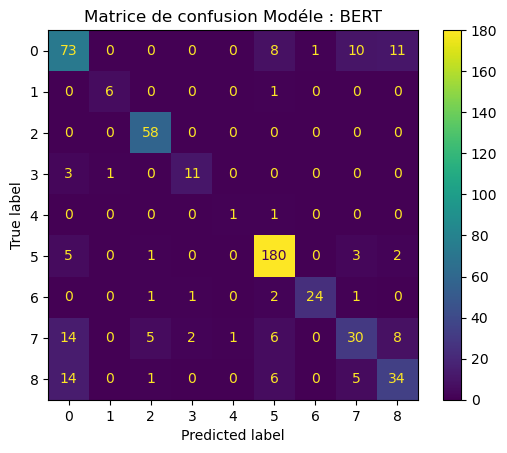

In [121]:
#Matrice de confusion model BERT
# Les probabilités de prédiction:
pred_probs_bert_test = torch.softmax(torch.tensor(prediction_values_bert_test), dim=1)
# Les classes prédites:
pred_labels_bert_test = torch.argmax(pred_probs_bert_test, dim=1)
# Les classes réelles
true_labels_test = my_dataset["test"]["label"]

# Visualisation graphique de la matrice de confusion
cm_bert = confusion_matrix(true_labels_test, pred_labels_bert_test)
disp_cm_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert)
disp_cm_bert.plot()
disp_cm_bert.ax_.set_title("Matrice de confusion Modéle : BERT")

Text(0.5, 1.0, 'Matrice de confusion Modéle : ELECTRA')

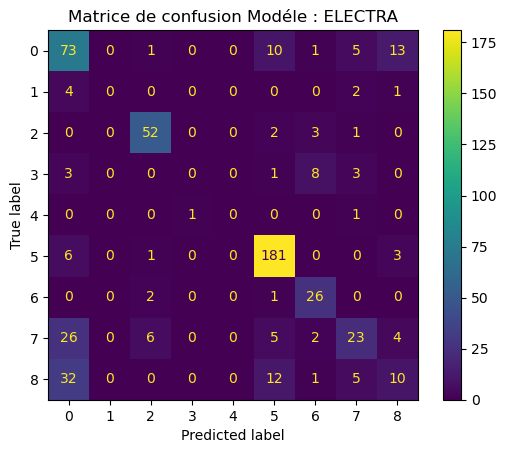

In [123]:
#Matrice de confusion model ELECTRA
# Les probabilités de prédiction:
pred_probs_electra_test = torch.softmax(torch.tensor(prediction_values_electra_test), dim=1)
# Les classes prédites:
pred_labels_electra_test = torch.argmax(pred_probs_electra_test, dim=1)
# Les classes réelles
true_labels_test = my_dataset["test"]["label"]

# Visualisation graphique de la matrice de confusion
cm_electra = confusion_matrix(true_labels_test, pred_labels_electra_test)
disp_cm_electra = ConfusionMatrixDisplay(confusion_matrix=cm_electra)
disp_cm_electra.plot()
disp_cm_electra.ax_.set_title("Matrice de confusion Modéle : ELECTRA")


### 4.2 Analyse des résultats

In [125]:
prediction_metrics_bert_test

{'test_loss': 0.801389217376709,
 'test_accuracy': 0.7853107344632768,
 'test_precision': 0.7770349279707707,
 'test_recall': 0.7853107344632768,
 'test_f1': 0.7784145155333989,
 'test_runtime': 169.5846,
 'test_samples_per_second': 3.131,
 'test_steps_per_second': 0.395}

In [127]:
prediction_metrics_electra_test

{'test_loss': 0.9647682309150696,
 'test_accuracy': 0.687382297551789,
 'test_precision': 0.6395975073393558,
 'test_recall': 0.687382297551789,
 'test_f1': 0.6517677509167913,
 'test_runtime': 167.4758,
 'test_samples_per_second': 3.171,
 'test_steps_per_second': 0.4}

Nous constatons une différence d'_accuracy_ générale entre les deux modèles lors de la prédiction des classes avec les données de test. Le modèle Bert obtient un score d'_accurracy_ de 78% et le modèle Electra un score de 68%. La précision pour le modèle Bert est de 77% et inférieure pour le modèle Electra avec 63.9%. Par conséquent le modèle BERT minimise mieux le nombre de Faux Positif. Également pour la métrique _Recall_, le modèle BERT est plus performant (78%) que le modèle Electra (68.7%).

La diagonale de la matrice de confusion du modèle Electra montre une incapacité du modèle à prédire certaine classe. En effet, les classes 1, 3 et 4 obtiennent un nombre d'échantillon correctement prédit de zéro. Ce constat est précisé par la métrique précision (TP / (TP + FP)) : 77% pour Bert comparativement à 63.9% pour Electra. Comme constaté lors de l'analyse de la répartition des classes dans l'échantillonnage de test, les classes 1, 3 et 4 avaient très peu d'enregistrement. Ceci ne permettrait pas au modèls Electra de capter assez de relations des mots lors de l'entrainement pour ces classes
La classe 8 est particuliérement moins bien prédite par le modèle Electra. Il ne résussit à prédire que 10 enregistrements correctement en comparaison des 34 bien prédits par le modèle BERT. 
.
Dans la documentation officielle d'Electra, la technique de MASK utilisé par BERT, est remplacée par une fonction de remplacement de jetons. Les jetons sont remplacés par des échantillons alternatifs au lieu de masquer l'entrée. Cette technique est moins adaptée au contenu de nos données.


### Conclusion
Le modèle Bert a une meilleure perfonrmace que le modèle Electra sans être pour autant d'une trés haute précision (77%).
Pour tenter d'améliorer les performamces de prédiction des deux modèles, il faudrait refaire une expréimentataion avec un nombre _epoch_ (3 par défaut) supérieur à 3 lors de l'entrainement afin parcourie plus de fois l'ensemble des données d'entrainement. de 
